# Combine GW190814 and GW190412

In this notebook we combine posteriors on the deviation parameters between GW190814 and GW190412.

We aim to calculate,

\begin{equation}
p(\vec{D}_{\ell m}|d_{190814}, d_{190412}) \propto p(\vec{D}_{\ell m}) \int \prod_{A=190412, 190814}
 \frac{p(\vec{D}_{\ell m}, \vec{\Theta}_{A}|d_{A})}{p(\vec{D}_{\ell m})} \mathrm{d} \vec{\Theta}_{A}
\end{equation}

where $\vec{D}_{\ell m} = \left\{\delta \mathcal{M}_{\ell m}, \delta \eta_{\ell m}\right\}$ and $\vec{\Theta}_A$ represent all of the other (event-dependent) parameters.

In [1]:
import os

#%matplotlib notebook
from matplotlib import pyplot

import numpy
from scipy.stats import gaussian_kde

from pycbc.inference import io
from pycbc.results.scatter_histograms import create_multidim_plot
from pycbc import conversions
from pycbc import waveform
from pycbc import transforms
from pycbc import coordinates
from pycbc.workflow import WorkflowConfigParser
from pycbc.inference.option_utils import prior_from_config

In [2]:
# the mode we'll combine
mode = 33
# whether we're using the mass-only or the all params run
mass_only = False
if mass_only:
    gw190814file = 'gw190814/posterior-mass_params.hdf'
    gw190412file = 'gw190412/posterior-mass_params.hdf'
else:
    gw190814file = 'gw190814/posterior-all_params.hdf'
    gw190412file = 'gw190412/posterior-all_params.hdf'
# the bandwidth we'll use for the kdes
kdebw = 'silverman'

## Load samples

### GW190814

In [3]:
# load the samples
fp = io.loadfile(gw190814file, 'r')
gw190814_samples = fp.read_samples(list(fp['samples'].keys()))
fp.close()

### GW190412

In [4]:
# load the samples
fp = io.loadfile(gw190412file, 'r')
gw190412_samples = fp.read_samples(list(fp['samples'].keys()))
fp.close()

We'll need some transforms for the spins.

In [5]:
class ConvertModeMass(transforms.BaseTransform):
    def __init__(self, mode):
        self.mode = mode
        self._inputs = [
            'srcmass1',
            'srcmass2',
            'fdiff_{}_mchirp'.format(mode),
            'fdiff_{}_eta'.format(mode),
        ]
        self._outputs = [
            'srcmass1_{}'.format(mode),
            'srcmass2_{}'.format(mode),
        ]
        super().__init__()
    
    def transform(self, maps):
        if isinstance(maps, dict):
            maps = FieldArray.from_kwargs(**maps)
        out = {}
        # calculate the mode masses
        m1 = maps['srcmass1']
        m2 = maps['srcmass2']
        mchirp = conversions.mchirp_from_mass1_mass2(m1, m2)
        mchirp_mode = mchirp*(1+maps['fdiff_{}_mchirp'.format(self.mode)])
        eta = conversions.eta_from_mass1_mass2(maps['srcmass1'], maps['srcmass2'])
        eta_mode = eta*(1+maps['fdiff_{}_eta'.format(self.mode)])
        m1mode = conversions.mass1_from_mchirp_eta(mchirp_mode, eta_mode)
        m2mode = conversions.mass2_from_mchirp_eta(mchirp_mode, eta_mode)
        out['srcmass1_{}'.format(mode)] = m1mode
        out['srcmass2_{}'.format(mode)] = m2mode
        return self.format_output(maps, out)   

In [6]:
tm = ConvertModeMass(mode)

In [7]:
gw190814_samples = transforms.apply_transforms(gw190814_samples, [tm])
gw190412_samples = transforms.apply_transforms(gw190412_samples, [tm])

## Build a KDE of each event's marginal posterior

We'll assume the different modes are independent of each other. However, because the $\Delta \vec{\chi}_{\ell m}$ prior is coupled to the $\vec{\chi}_{22}$, we need to build the KDEs over all the intrinsic parameters. Namely, $\delta \mathcal{M}_{\ell m}$, $\delta \eta_{\ell m}$, $\Delta \vec{\chi}_{1,\ell m}$, $\Delta \vec{\chi}_{2, \ell m}$, $\vec{\chi}_{1,22}$, $\vec{\chi}_{2,22}$, and $\Delta \phi_{c,\ell m}$. So 15 parameters total.

In [8]:
from pycbc.distributions import Arbitrary

In [9]:
param_bounds = {
    'fdiff_{}_mchirp'.format(mode): (-0.5, 0.5),
    'fdiff_{}_eta'.format(mode): (-0.5, 0.5),
}

In [10]:
event_params = {}
event_param_bounds = {}
for p in param_bounds:
    event_params[p] = gw190814_samples[p]
    event_param_bounds[p] = param_bounds[p]
gw190814post = Arbitrary(**event_params, bandwidth=kdebw)

In [11]:
event_params = {}
event_param_bounds = {}
for p in param_bounds:
    event_params[p] = gw190412_samples[p]
    event_param_bounds[p] = param_bounds[p]
gw190412post = Arbitrary(**event_params, bandwidth=kdebw)

In [12]:
event_posteriors = {'gw190412': gw190412post,
                    'gw190814': gw190814post
                   }

### Check
Check that the posterior KDEs are accurately modelling the originals.

#### GW190814

Original:

using scipy KDE with bw: None


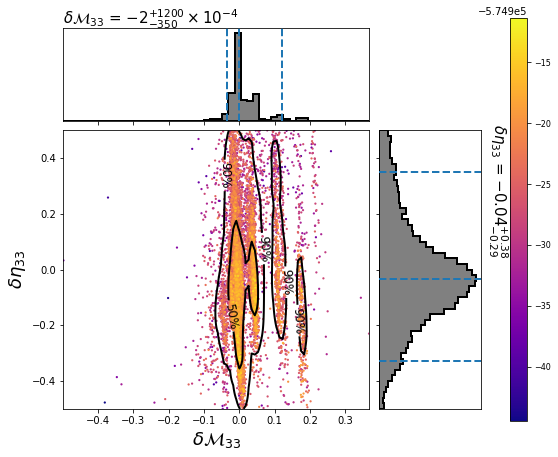

In [13]:
labels = {'fdiff_{}_mchirp'.format(mode): '$\delta \mathcal{{M}}_{{{}}}$'.format(mode),
          'fdiff_{}_eta'.format(mode): '$\delta \eta_{{{}}}$'.format(mode),
         }
fig, axis_dict = create_multidim_plot(list(labels.keys()), gw190814_samples,
                                      labels=labels, plot_marginal=True, plot_scatter=True,
                                      plot_contours=True,
                                      zvals=gw190814_samples['loglikelihood']
                                     )
fig.show()

Fit:

In [14]:
resamps = gw190814post.rvs(size=12800)
logls = numpy.array([gw190412post(**{p: resamps[p][ii] for p in labels}) for ii in range(resamps.size)])

using scipy KDE with bw: None


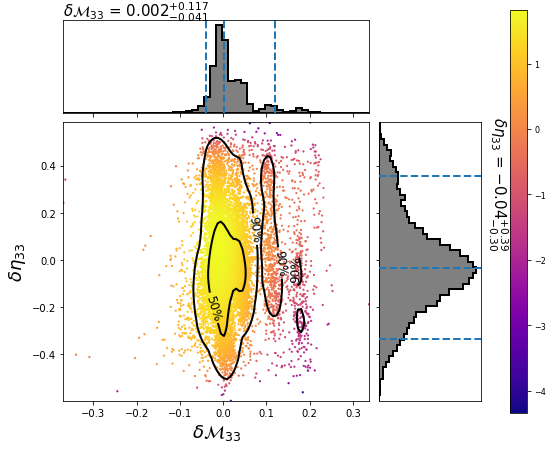

In [15]:
fig, axis_dict = create_multidim_plot(list(labels.keys()), resamps,
                                      labels=labels, plot_marginal=True, plot_scatter=True,
                                      plot_contours=True,
                                      zvals=logls
                                     )
fig.show()

#### GW190412

Original:

using scipy KDE with bw: None


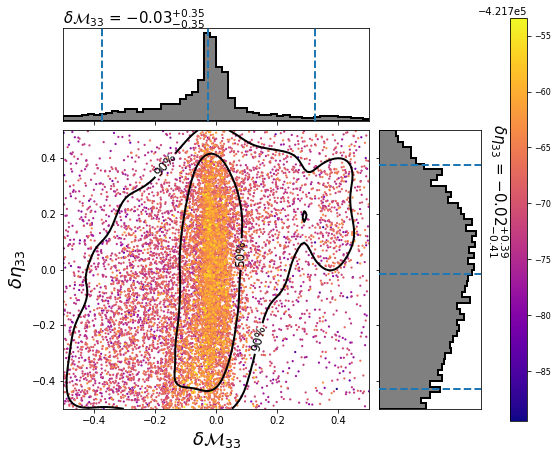

In [16]:
fig, axis_dict = create_multidim_plot(list(labels.keys()), gw190412_samples,
                                      labels=labels, plot_marginal=True, plot_scatter=True,
                                      plot_contours=True,
                                      zvals=gw190412_samples['loglikelihood']
                                     )
fig.show()

Fit:

In [17]:
post = gw190412post
resamps = post.rvs(size=12800)
logls = numpy.array([post(**{p: resamps[p][ii] for p in labels}) for ii in range(resamps.size)])

using scipy KDE with bw: None


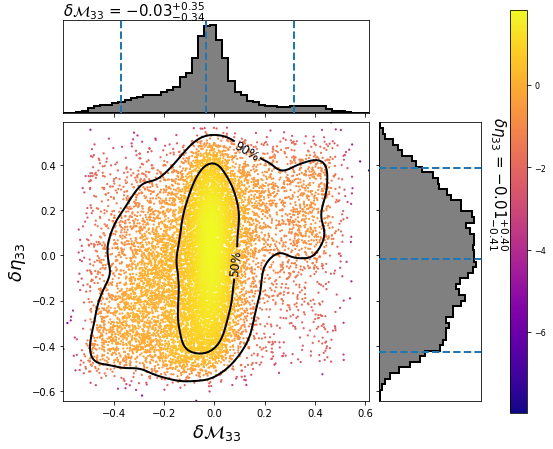

In [18]:
fig, axis_dict = create_multidim_plot(list(labels.keys()), resamps,
                                      labels=labels, plot_marginal=True, plot_scatter=True,
                                      plot_contours=True,
                                      zvals=logls
                                     )
fig.show()

## Setup the prior

In [19]:
from pycbc import distributions
from pycbc import coordinates
from pycbc.io import FieldArray

In [20]:
prior_massphi = distributions.Uniform(**{'fdiff_{}_mchirp'.format(mode): (-0.5, 0.5),
                                         'fdiff_{}_eta'.format(mode): (-0.5, 0.5),
                                        })

In [21]:
# the combined prior
priors = [prior_massphi]
varparams = [param for p in priors for param in p.params]
prior = distributions.JointDistribution(varparams, *priors)
print(prior.variable_args)

('fdiff_33_eta', 'fdiff_33_mchirp')


In [22]:
# each event's prior: these will be divided from the events'
# posteriors
event_priors = {}
for event in event_posteriors:
    priors = [prior_massphi]
    varparams = [param for p in priors for param in p.params]
    event_priors[event] = distributions.JointDistribution(varparams, *priors)

In [23]:
event_priors['gw190412'].variable_args

('fdiff_33_eta', 'fdiff_33_mchirp')

## Do an MCMC to combine the deviation parameters

In [24]:
from pycbc.inference.models.base import BaseModel

In [25]:
class CombinedModel(BaseModel):
    """Model for combining deviation parameters.
    
    Parameters
    ----------
    variable_params : list
        List of the variable parameters.
    event_posteriors : dict
        Dictionary of event names -> marginalized posteriors.
    event_priors : dict
        Dictionary of event names -> priors that were used.
    prior : JointDistribution
        The prior to use for the combined parameters.
    \**kwargs :
        All other keyword arguments are passed to ``BaseModel``.
    """
    name = 'combined'
    
    def __init__(self, variable_params, event_posteriors, event_priors, prior, **kwargs):
        super().__init__(variable_params, prior=prior, **kwargs)
        if set(event_posteriors.keys()) != set(event_priors.keys()):
            raise ValueError("event posteriors and priors must have same events")
        self.event_posteriors = event_posteriors
        self.event_priors = event_priors
    
    def _loglikelihood(self):
        logl = 0
        for event, post in self.event_posteriors.items():
            prior = self.event_priors[event]
            #params = {p: self.current_params[p] for p in prior.variable_args}
            logpost = post(**self.current_params)
            logprior = prior(**self.current_params)
            if logpost == -numpy.inf or logprior == -numpy.inf:
                return -numpy.inf
            else:
                logl += logpost - logprior
        return logl

In [26]:
model = CombinedModel(prior.variable_args, event_posteriors, event_priors, prior)

In [27]:
len(model.variable_params)

2

### Sample

In [28]:
from pycbc.inference import sampler as samplers
from pycbc.inference.sampler.base import setup_output
from pycbc.inference import burn_in

In [29]:
import pycbc
import logging
pycbc.init_logging(True)

In [30]:
nwalkers = 200
ntemps = 4
checkpoint_interval = 100
nprocesses = 8
sampler = samplers.EmceePTSampler(model, ntemps, nwalkers, checkpoint_interval=checkpoint_interval,
                                  nprocesses=nprocesses)

In [31]:
sampler.set_burn_in(burn_in.EnsembleMultiTemperedMCMCBurnInTests(sampler, 'max_posterior & nacl'))

In [32]:
output_file = 'combined_results-{}-{}.hdf'.format('mass_only_run' if mass_only else 'all_params_run',
                                                    kdebw)

In [33]:
setup_output(sampler, output_file)

2020-08-25 14:07:01,242 Looking for checkpoint file
2020-08-25 14:07:01,244 Checkpoint not found or not valid
2020-08-25 14:07:01,245 Creating file combined_results-all_params_run-silverman.hdf.checkpoint


In [34]:
if not sampler.new_checkpoint:
    sampler.resume_from_checkpoint()
else:
    sampler.set_p0(prior=gw190814post)

In [35]:
sampler.set_target(eff_nsamples=5000)

In [36]:
sampler.run()

2020-08-25 14:07:01,290 Running sampler for 0 to 100 iterations
/work/cdcapano/virtualenv/py37-multimodes/lib/python3.7/site-packages/emcee/ptsampler.py:335: RuntimeWarning: invalid value encountered in subtract
  - lnprob[:, jupdate::2]
/work/cdcapano/virtualenv/py37-multimodes/lib/python3.7/site-packages/emcee/ptsampler.py:340: RuntimeWarning: invalid value encountered in less
  accepts = logrs < logpaccept
/work/cdcapano/virtualenv/py37-multimodes/lib/python3.7/site-packages/emcee/ptsampler.py:402: RuntimeWarning: invalid value encountered in subtract
  - dbeta * logl[i - 1, i1perm[asel]]
2020-08-25 14:07:31,408 Writing samples to combined_results-all_params_run-silverman.hdf.checkpoint with thin interval 1
2020-08-25 14:07:31,432 Writing samples to combined_results-all_params_run-silverman.hdf.bkup with thin interval 1
2020-08-25 14:07:31,460 Updating burn in
2020-08-25 14:07:31,461 Evaluating max_posterior burn-in test
2020-08-25 14:07:31,473 Evaluating nacl burn-in test
2020-08-2

In [37]:
sampler._sampler.pool.close()

In [38]:
os.rename(sampler.checkpoint_file, output_file)
os.remove(sampler.backup_file)

In [39]:
# extract the posterior
posterior_file = output_file.replace('results', 'posterior')

In [40]:
!pycbc_inference_extract_samples --input-file {output_file} \
    --output-file {posterior_file} --skip-groups sampler_info \
    --verbose --force

2020-08-25 14:09:16,812 Reading input file combined_results-all_params_run-silverman.hdf
2020-08-25 14:09:16,816 Loading samples
2020-08-25 14:09:16,845 Loaded 7200 samples
2020-08-25 14:09:16,869 Copying info


In [41]:
from IPython.display import Image
from IPython.core.display import HTML

In [42]:
plotfile = 'combined_post-masses-{}-{}.png'.format('mass_only_run' if mass_only else 'all_params_run',
                                                   kdebw)

In [43]:
plotparams = r"'fdiff_33_mchirp:$\delta \mathcal{M}_{33}$' 'fdiff_33_eta:$\delta \eta_{33}$'"

In [44]:
!pycbc_inference_plot_posterior --input-file {posterior_file} \
    --output-file {plotfile} \
    --parameters {plotparams} \
    --plot-contours --plot-scatter --plot-marginal --z-arg loglikelihood --verbose

2020-08-25 14:09:20,414 Reading input file combined_posterior-all_params_run-silverman.hdf
2020-08-25 14:09:20,417 Loading samples
2020-08-25 14:09:20,421 Loaded 7200 samples
2020-08-25 14:09:20,422 Getting samples for colorbar
2020-08-25 14:09:20,424 Plotting
using scipy KDE with bw: None
2020-08-25 14:09:24,709 Done


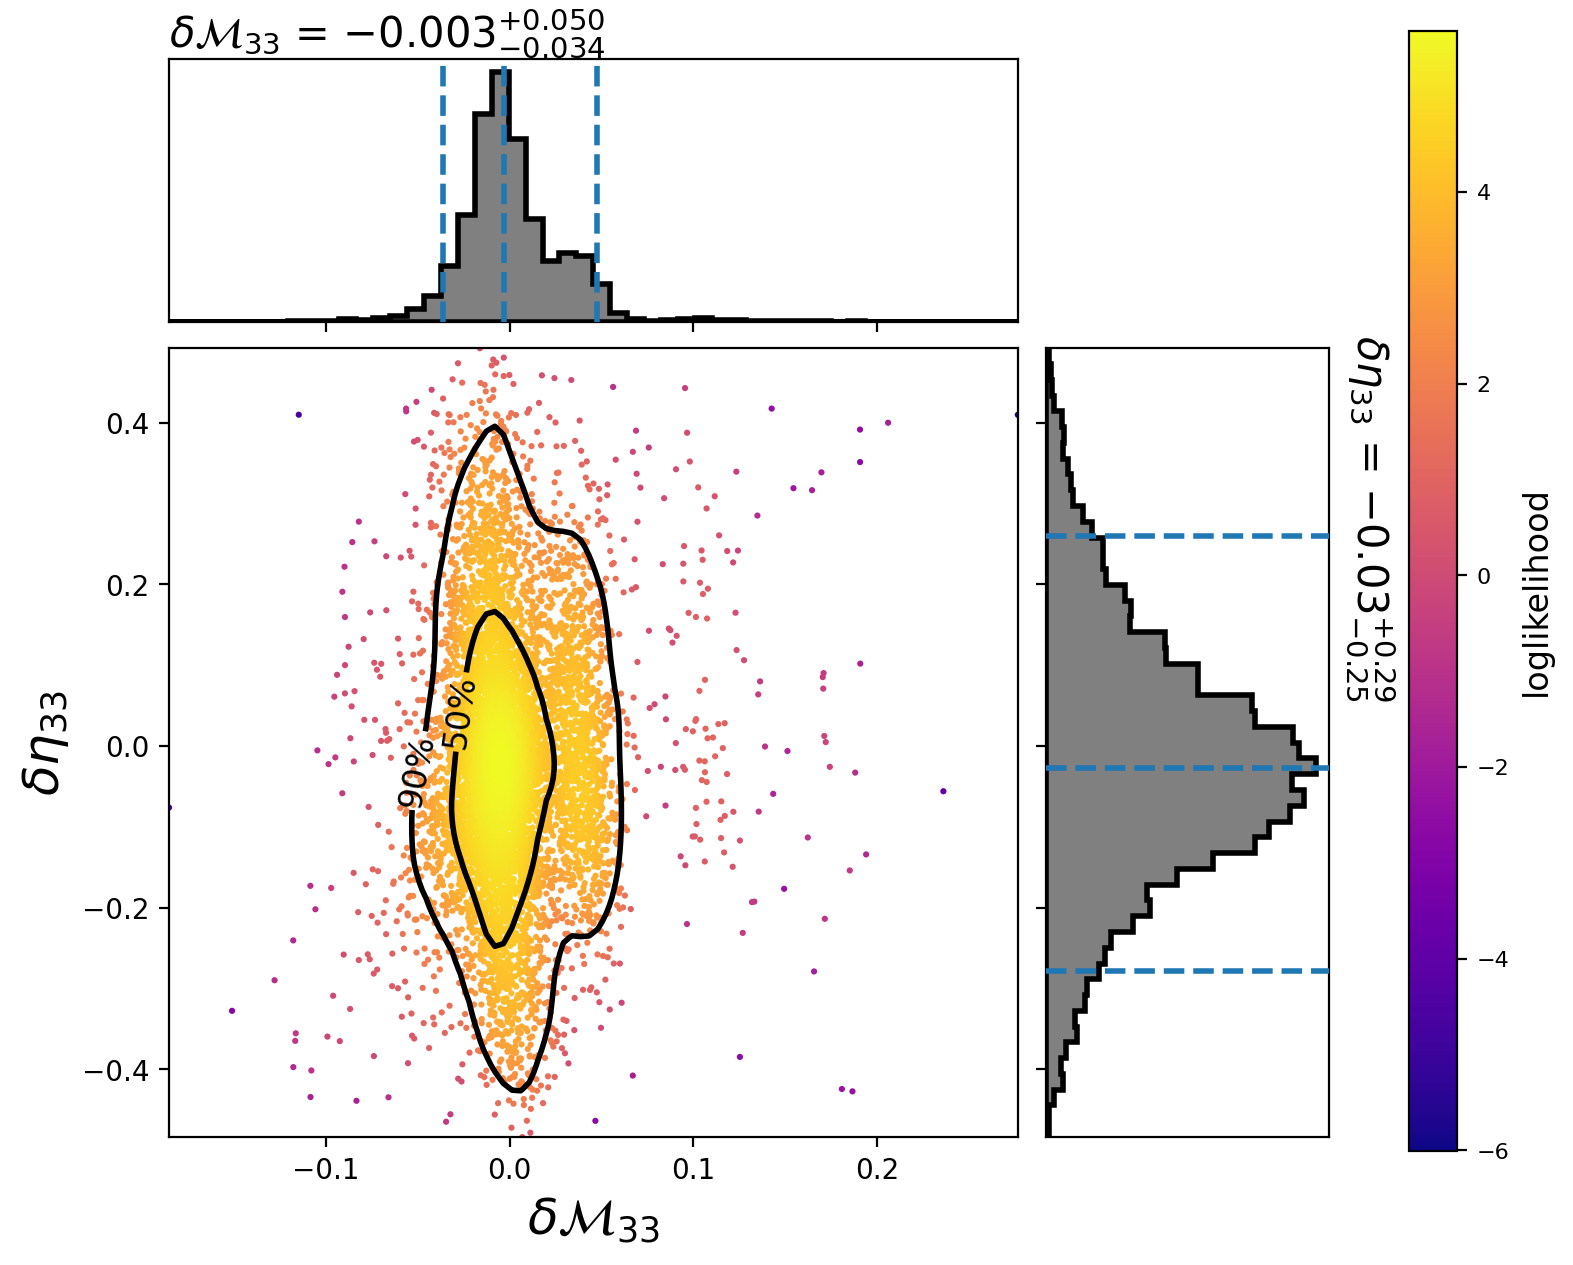

In [45]:
Image(filename=plotfile, width=640, height=480)

In [46]:
plotfile = 'compare-masses-{}-{}.png'.format('mass_only_run' if mass_only else 'all_params_run',
                                             kdebw)

In [47]:
input_files = '{}:GW190412 {}:GW190814 {}:Combined'.format(gw190412file, gw190814file, posterior_file)
mins = 'fdiff_33_mchirp:-0.05'
maxs = 'fdiff_33_mchirp:0.05'

In [48]:
!pycbc_inference_plot_posterior \
    --input-file {input_files} \
    --output-file {plotfile} \
    --parameters {plotparams} \
    --plot-contours --plot-marginal \
    --mins {mins} \
    --maxs {maxs} \
    --marginal-percentiles 5 95 \
    --verbose

2020-08-25 14:09:28,270 Reading input file gw190412/posterior-all_params.hdf
2020-08-25 14:09:28,273 Loading samples
2020-08-25 14:09:28,280 Loaded 12000 samples
2020-08-25 14:09:28,281 Reading input file gw190814/posterior-all_params.hdf
2020-08-25 14:09:28,284 Loading samples
2020-08-25 14:09:28,290 Loaded 12800 samples
2020-08-25 14:09:28,291 Reading input file combined_posterior-all_params_run-silverman.hdf
2020-08-25 14:09:28,294 Loading samples
2020-08-25 14:09:28,298 Loaded 7200 samples
2020-08-25 14:09:28,299 Plotting
using scipy KDE with bw: None
using scipy KDE with bw: None
using scipy KDE with bw: None
2020-08-25 14:09:42,662 Done


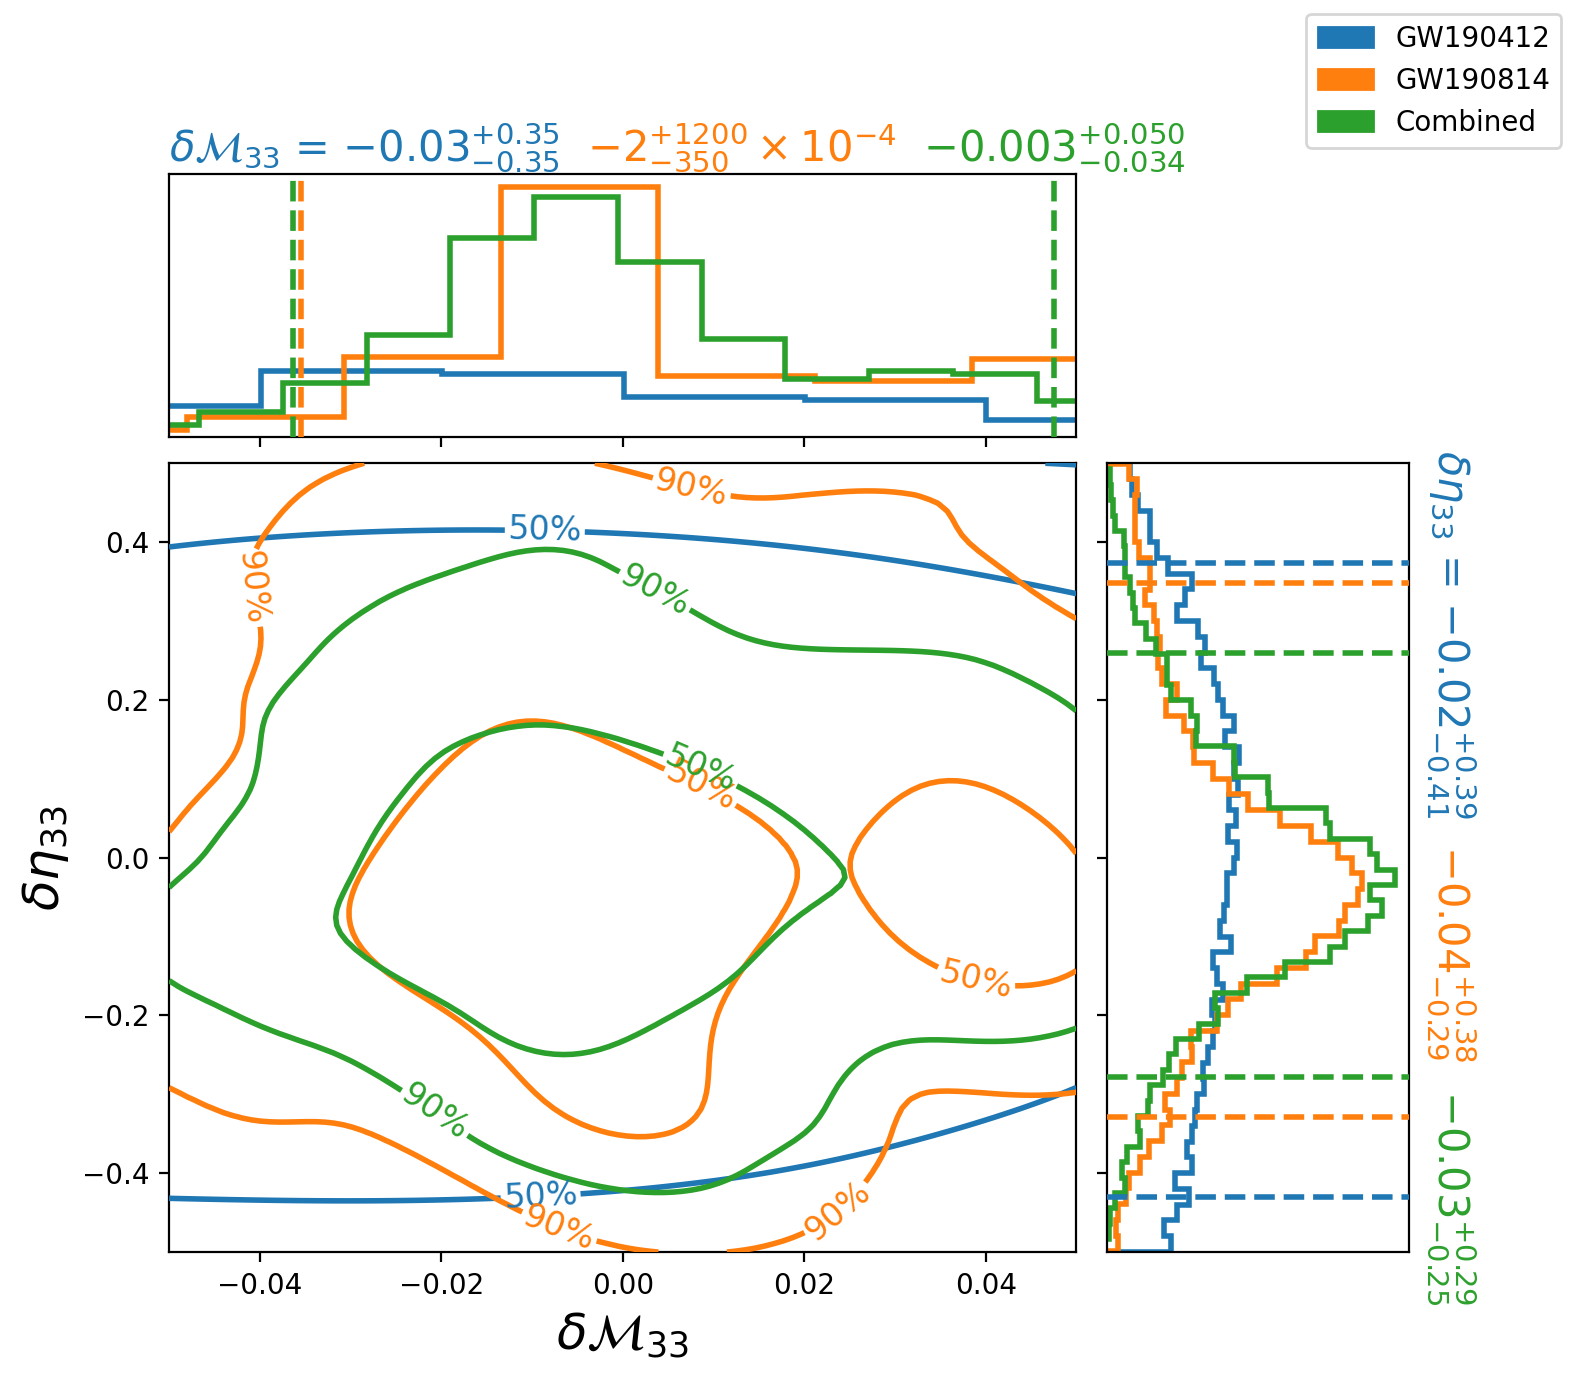

In [49]:
Image(filename=plotfile, width=640, height=480)